# LBA Field Visualizations

Time-height diagrams and animations for MONC LBA data.

**Prerequisites:** Run `lba_input_validation.ipynb` first to verify data integrity.

In [50]:
import glob
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation

## 1. Configuration and Data Loading

In [51]:
# === USER CONFIGURATION ===
DATA_PATH = '/Users/jure/PhD/coding/LBA_sample_data/jun10'

In [52]:
# Find and load all 3dfields files
pattern = str(Path(DATA_PATH) / '3dfields_ts_*.nc')
files_3d = sorted(glob.glob(pattern))

# Load and merge along time
ds = xr.open_mfdataset(files_3d, combine='by_coords')

# Get grid info from data
# x and y are index dimensions; zn and z contain actual height values (non-uniform vertical grid)
nx, ny = ds.sizes['x'], ds.sizes['y']
zn_vals = ds.zn.values  # Actual height values from NetCDF (scalar levels)
z_vals = ds.z.values    # Actual w-level heights from NetCDF

# Assign x, y coordinates in meters (horizontal grid spacing)
# Adjust dx if your simulation uses different horizontal resolution
dx = 200.0  # metres
ds = ds.assign_coords(
    x=('x', np.arange(nx) * dx),
    y=('y', np.arange(ny) * dx)
)
ds.x.attrs['units'] = 'm'
ds.y.attrs['units'] = 'm'

print(f"Loaded {len(files_3d)} files")
print(f"Dataset dimensions: {dict(ds.sizes)}")
print(f"Vertical levels (zn): {len(zn_vals)} levels, height range: {zn_vals.min():.0f} - {zn_vals.max():.0f} m")

Loaded 21 files
Dataset dimensions: {'time_series_180_180': 21, 'x': 256, 'y': 256, 'z': 211, 'zn': 211, 'number_options': 1274, 'kvp': 2}
Vertical levels (zn): 211 levels, height range: -25 - 22900 m


In [53]:
# Identify time dimension
time_dims = [d for d in ds.dims if d.startswith('time_series_')]
if not time_dims:
    raise ValueError("No time_series_* dimension found")
TIME_DIM = time_dims[0]

time_sec = ds[TIME_DIM].values
time_min = time_sec / 60

print(f"Time dimension: {TIME_DIM}")
print(f"Time range: {time_min.min():.1f} - {time_min.max():.1f} minutes")
print(f"Number of timesteps: {len(time_sec)}")

if len(time_sec) > 1:
    dt = np.diff(time_sec)
    print(f"Output interval: {dt[0]:.0f} seconds ({dt[0]/60:.1f} minutes)")

Time dimension: time_series_180_180
Time range: 120.0 - 180.0 minutes
Number of timesteps: 21
Output interval: 180 seconds (3.0 minutes)


## 2. Condensate Time-Height Diagram

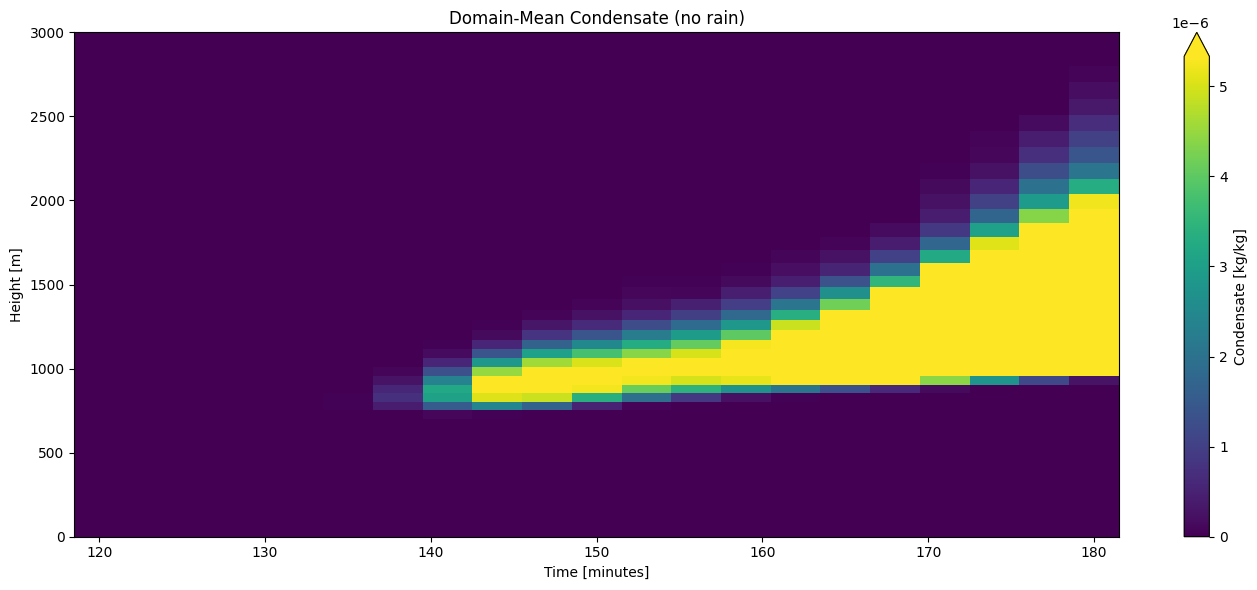

In [54]:
# Calculate total condensate (excluding rain)
condensate = (
    ds.q_cloud_liquid_mass 
    + ds.q_ice_mass 
    + ds.q_snow_mass 
    + ds.q_graupel_mass
)

# Domain mean
cond_mean = condensate.mean(dim=['x', 'y'])

# Create time in minutes coordinate for plotting
ds_plot = cond_mean.assign_coords({TIME_DIM: time_min})

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

p = ds_plot.plot(
    x=TIME_DIM, y='zn', ax=ax,
    cmap='viridis', robust=True,
    cbar_kwargs={'label': 'Condensate [kg/kg]'}
)

ax.set_xlabel('Time [minutes]')
ax.set_ylabel('Height [m]')
ax.set_title('Domain-Mean Condensate (no rain)')
ax.set_ylim([0, 3000])

plt.tight_layout()
plt.show()

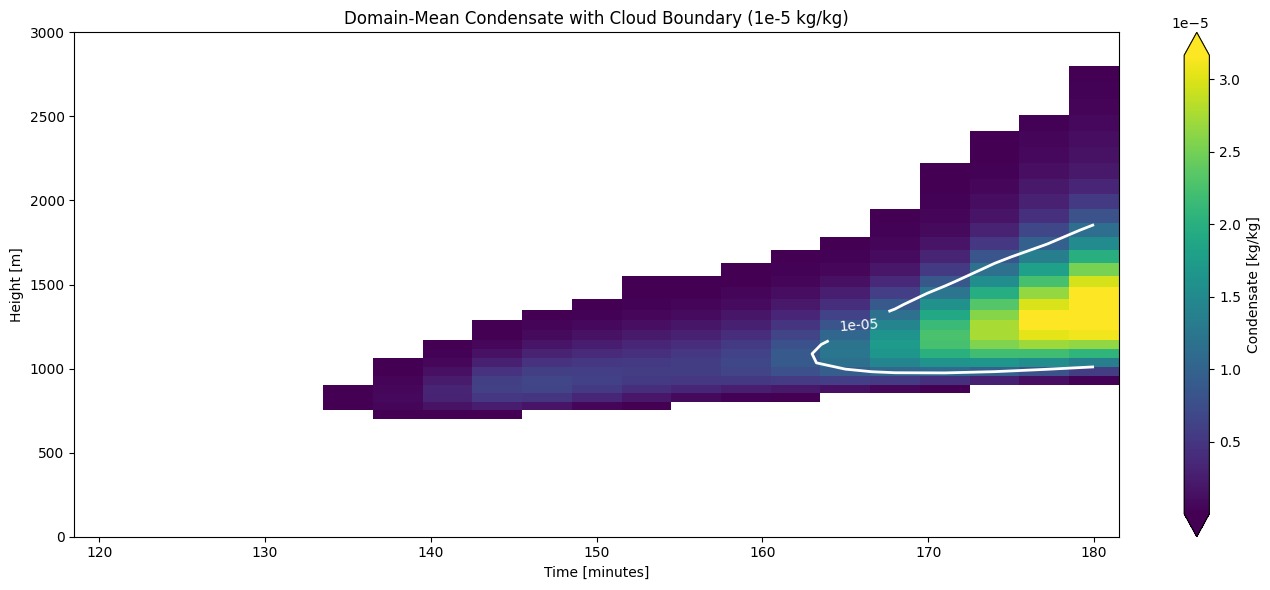

In [55]:
# Condensate with cloud boundary contour
fig, ax = plt.subplots(figsize=(14, 6))

# Mask zero values
cond_masked = cond_mean.where(cond_mean > 1e-8)
cond_masked_plot = cond_masked.assign_coords({TIME_DIM: time_min})

p = cond_masked_plot.plot(
    x=TIME_DIM, y='zn', ax=ax,
    cmap='viridis', robust=True,
    cbar_kwargs={'label': 'Condensate [kg/kg]'}
)

# Add cloud boundary contour (1e-5 kg/kg)
z_vals_zn = cond_mean['zn'].values
cond_data = cond_mean.transpose('zn', TIME_DIM).values

CS = ax.contour(time_min, z_vals_zn, cond_data, levels=[1e-5], colors='white', linewidths=2)
ax.clabel(CS, inline=True, fontsize=10, fmt='%.0e')

ax.set_xlabel('Time [minutes]')
ax.set_ylabel('Height [m]')
ax.set_title('Domain-Mean Condensate with Cloud Boundary (1e-5 kg/kg)')
ax.set_ylim([0, 3000])

plt.tight_layout()
plt.show()

## 3. Individual Water Species

In [56]:
# Define water species
water_species = {
    'Cloud Liquid': ds.q_cloud_liquid_mass,
    'Ice': ds.q_ice_mass,
    'Snow': ds.q_snow_mass,
    'Graupel': ds.q_graupel_mass,
    'Rain': ds.q_rain_mass,
}

# Domain means
mean_species = {name: var.mean(dim=['x', 'y']) for name, var in water_species.items()}

# Add totals
mean_species['Total Condensate'] = (
    mean_species['Cloud Liquid'] + mean_species['Ice'] 
    + mean_species['Snow'] + mean_species['Graupel']
)
mean_species['Total Water'] = mean_species['Total Condensate'] + mean_species['Rain']

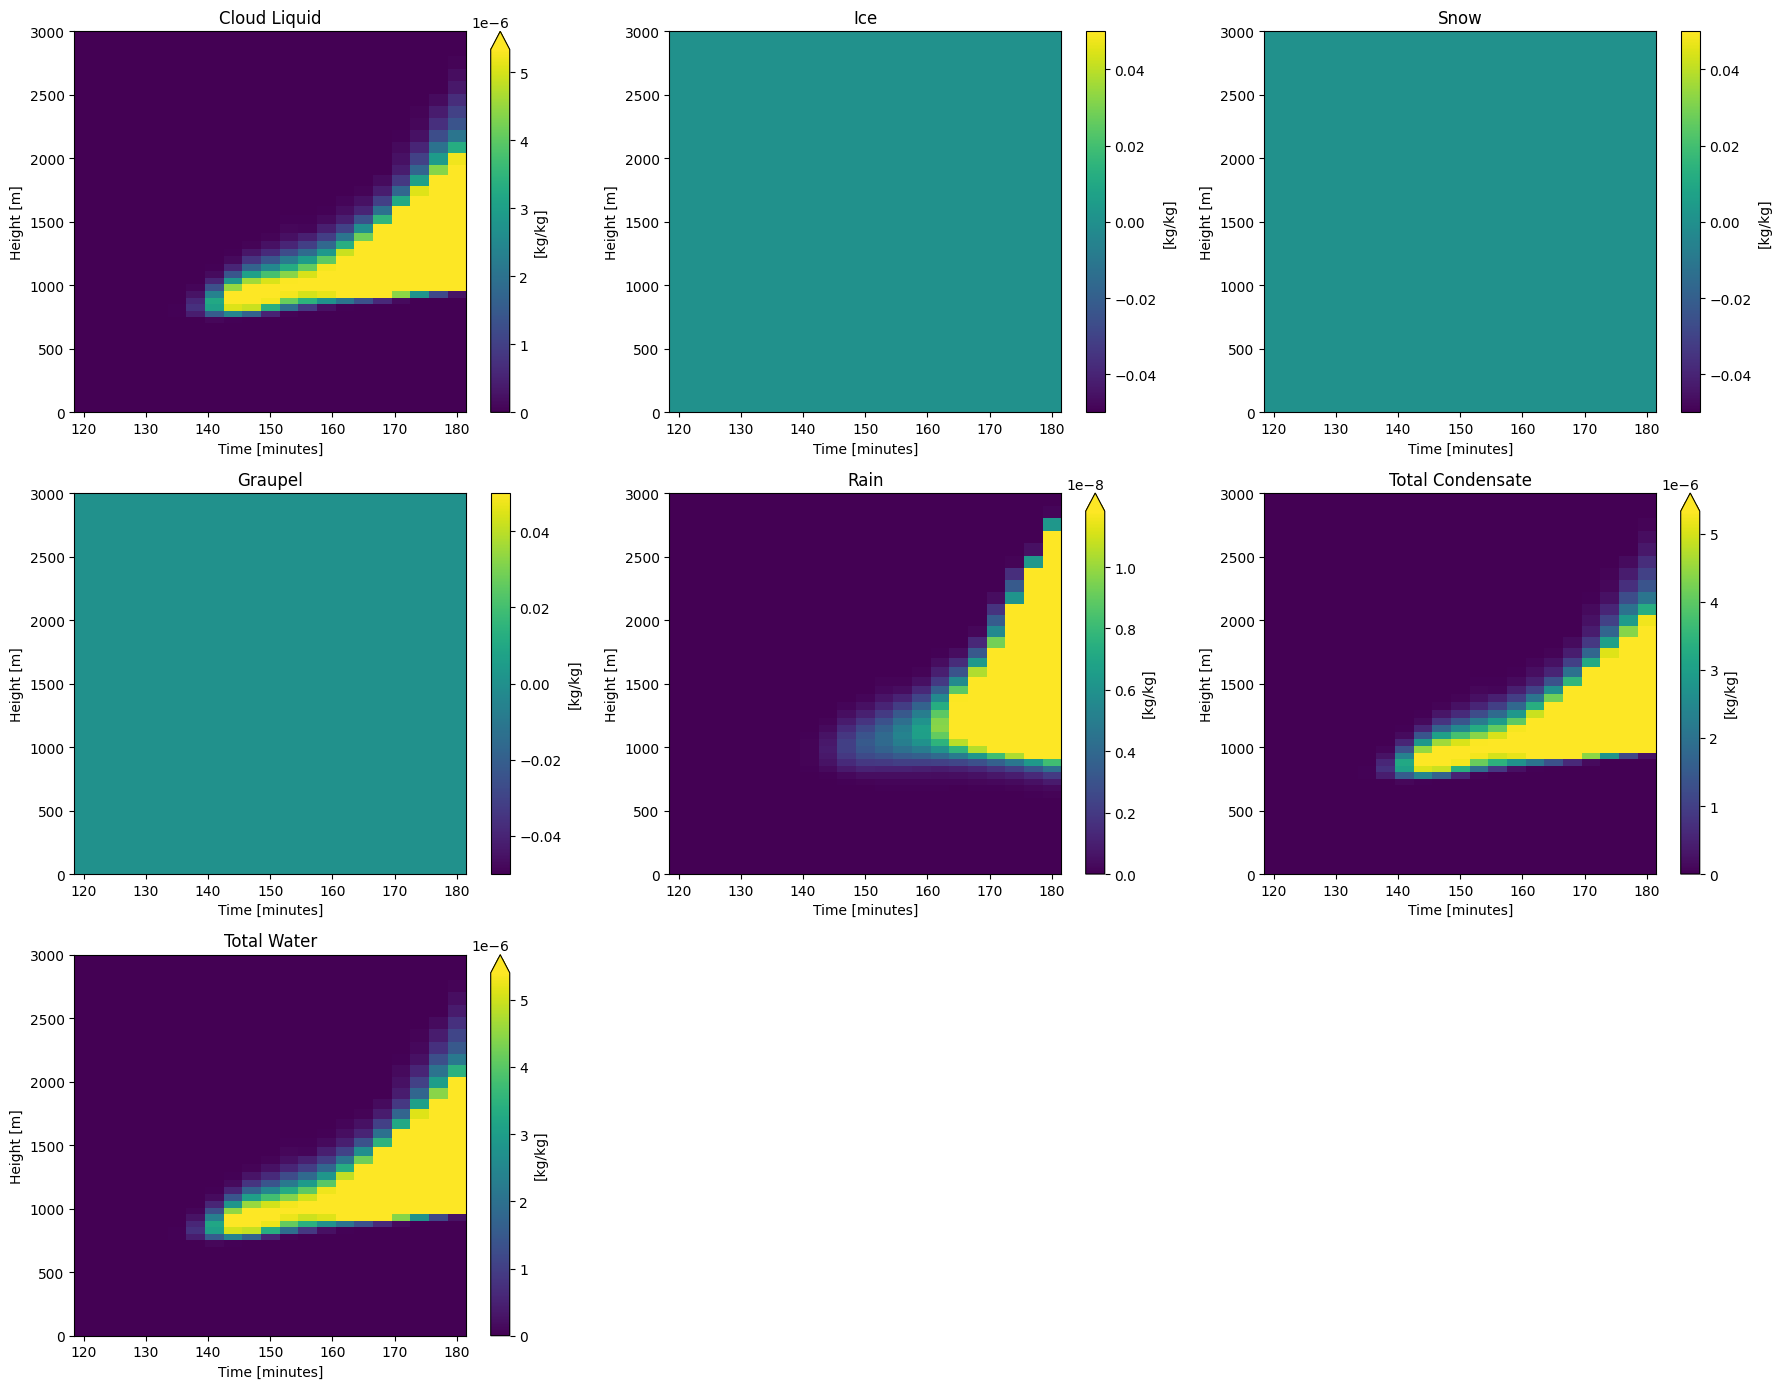

In [57]:
# Plot all species
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, (name, data) in enumerate(mean_species.items()):
    ax = axes[i]
    
    # Assign time in minutes for plotting
    data_plot = data.assign_coords({TIME_DIM: time_min})
    
    data_plot.plot(
        x=TIME_DIM, y='zn', ax=ax,
        cmap='viridis', robust=True,
        cbar_kwargs={'label': '[kg/kg]'}
    )
    
    ax.set_title(f'{name}')
    ax.set_xlabel('Time [minutes]')
    ax.set_ylabel('Height [m]')
    ax.set_ylim([0, 3000])

# Remove unused axes
for j in range(len(mean_species), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4. Wind Profiles Over Time

In [58]:
# Domain-mean wind profiles
u_mean = ds.u.mean(dim=['x', 'y'])
v_mean = ds.v.mean(dim=['x', 'y'])
w_mean = ds.w.mean(dim=['x', 'y'])

# Get actual height values from NetCDF
zn = ds.zn.values  # scalar levels (for u, v)
z_w = ds.z.values  # w levels

n_times = len(time_sec)

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_44450/2630942978.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


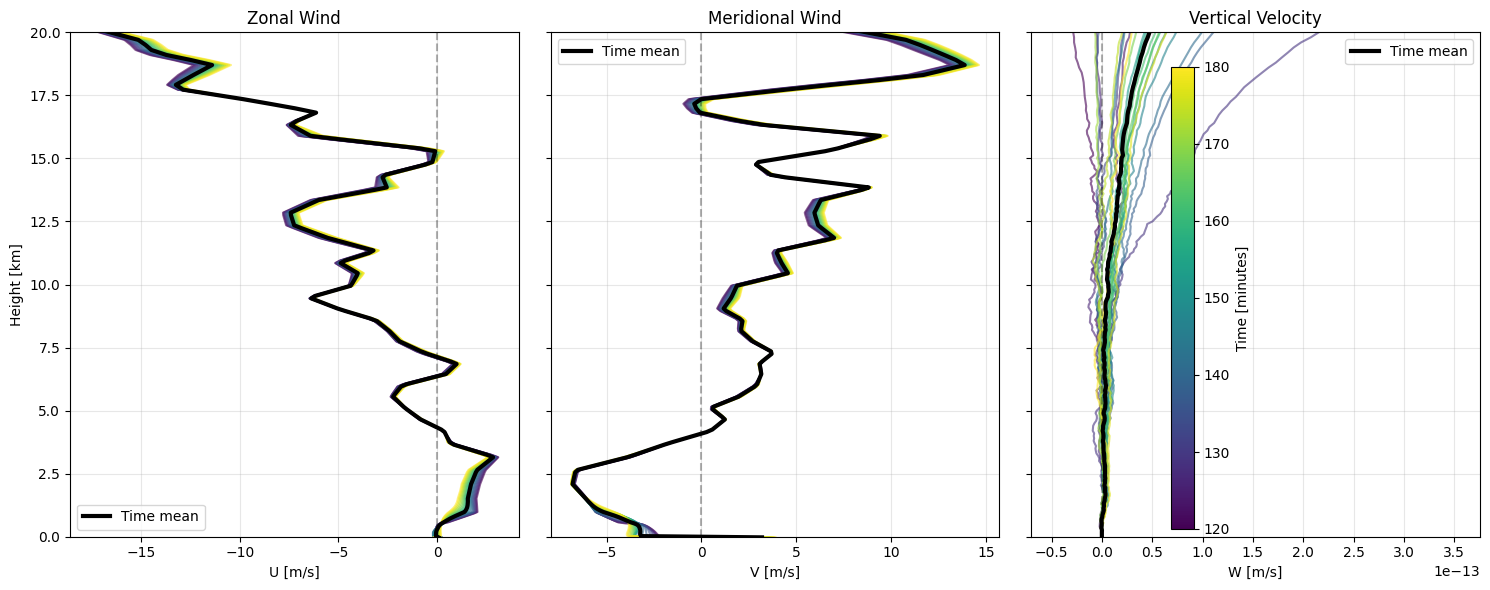

In [59]:
# Plot wind evolution
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

cmap = plt.cm.viridis
colors = [cmap(i / max(1, n_times - 1)) for i in range(n_times)]

# U profiles
for t in range(n_times):
    u_prof = u_mean.isel({TIME_DIM: t}).values
    axes[0].plot(u_prof, zn / 1000, color=colors[t], alpha=0.6)

u_time_mean = u_mean.mean(dim=TIME_DIM).values
axes[0].plot(u_time_mean, zn / 1000, 'k-', linewidth=3, label='Time mean')
axes[0].axvline(0, color='k', linestyle='--', alpha=0.3)
axes[0].set_xlabel('U [m/s]')
axes[0].set_ylabel('Height [km]')
axes[0].set_title('Zonal Wind')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# V profiles
for t in range(n_times):
    v_prof = v_mean.isel({TIME_DIM: t}).values
    axes[1].plot(v_prof, zn / 1000, color=colors[t], alpha=0.6)

v_time_mean = v_mean.mean(dim=TIME_DIM).values
axes[1].plot(v_time_mean, zn / 1000, 'k-', linewidth=3, label='Time mean')
axes[1].axvline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('V [m/s]')
axes[1].set_title('Meridional Wind')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# W profiles
for t in range(n_times):
    w_prof = w_mean.isel({TIME_DIM: t}).values
    axes[2].plot(w_prof, z_w / 1000, color=colors[t], alpha=0.6)

w_time_mean = w_mean.mean(dim=TIME_DIM).values
axes[2].plot(w_time_mean, z_w / 1000, 'k-', linewidth=3, label='Time mean')
axes[2].axvline(0, color='k', linestyle='--', alpha=0.3)
axes[2].set_xlabel('W [m/s]')
axes[2].set_title('Vertical Velocity')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.set_ylim([0, 20])

# Add colorbar for time (in minutes)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(time_min.min(), time_min.max()))
cbar = fig.colorbar(sm, ax=axes, label='Time [minutes]', pad=0.02)

plt.tight_layout()
plt.show()

## 5. Horizontal Slices

In [60]:
# Select timestep and level for slices
time_idx = max(5, n_times - 1)  # Use later timestep if available
z_level = 25  # Adjust based on your data

# Get actual height value from NetCDF
height_m = ds.zn.isel(zn=z_level).values
actual_time_min = time_sec[time_idx] / 60

print(f"Plotting: timestep {time_idx}, t = {actual_time_min:.1f} min")
print(f"          level {z_level}, z = {height_m:.0f} m")

Plotting: timestep 20, t = 180.0 min
          level 25, z = 1258 m


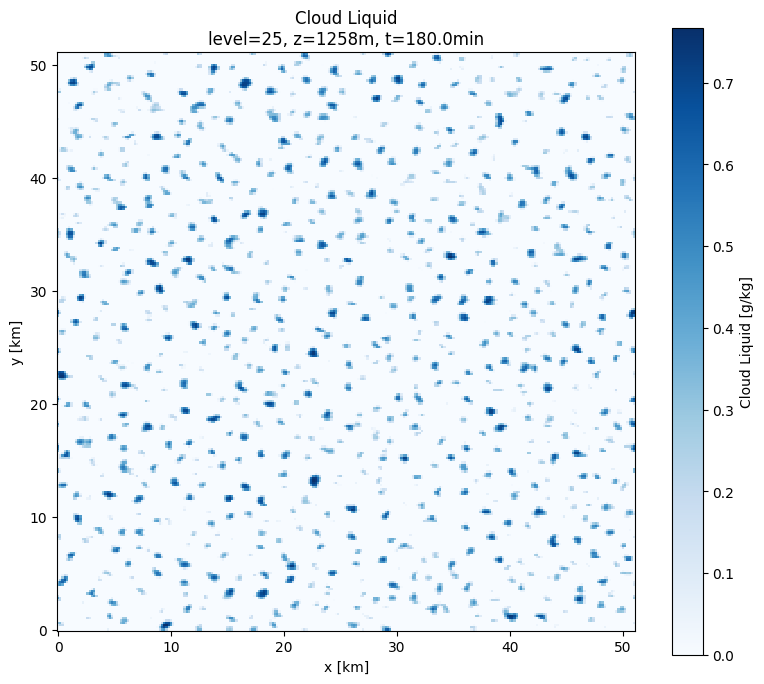

In [61]:
# Cloud liquid horizontal slice
qcl = ds.q_cloud_liquid_mass.isel({TIME_DIM: time_idx, 'zn': z_level})

fig, ax = plt.subplots(figsize=(8, 7))

im = ax.pcolormesh(
    ds.x / 1000, ds.y / 1000, qcl * 1000,
    shading='auto', cmap='Blues'
)
plt.colorbar(im, ax=ax, label='Cloud Liquid [g/kg]')

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title(f'Cloud Liquid\nlevel={z_level}, z={height_m:.0f}m, t={actual_time_min:.1f}min')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
# Create animated GIF of cloud liquid at this height level
if n_times < 2:
    print("Animation requires multiple timesteps. Skipping.")
else:
    time_indices = list(range(n_times))
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Get colorbar range from all timesteps for consistent scaling
    qcl_all = ds.q_cloud_liquid_mass.isel({'zn': z_level}) * 1000  # g/kg
    vmax = float(qcl_all.max())
    vmax = max(vmax, 0.01)  # Ensure non-zero max
    
    def update_frame(frame):
        ax.clear()
        
        qcl_frame = ds.q_cloud_liquid_mass.isel({TIME_DIM: frame, 'zn': z_level})
        t_min = time_sec[frame] / 60
        
        im = ax.pcolormesh(
            ds.x.values / 1000, ds.y.values / 1000, qcl_frame.values * 1000,
            shading='auto', cmap='Blues', vmin=0, vmax=vmax
        )
        
        ax.set_xlabel('x [km]')
        ax.set_ylabel('y [km]')
        ax.set_title(f'Cloud Liquid at z = {height_m:.0f} m\nt = {t_min:.1f} minutes')
        ax.set_aspect('equal')
        
        return [im]
    
    # Add colorbar (only once, outside animation)
    # Create a dummy plot for colorbar
    im_dummy = ax.pcolormesh(
        ds.x.values / 1000, ds.y.values / 1000, 
        ds.q_cloud_liquid_mass.isel({TIME_DIM: 0, 'zn': z_level}).values * 1000,
        shading='auto', cmap='Blues', vmin=0, vmax=vmax
    )
    cbar = fig.colorbar(im_dummy, ax=ax, label='Cloud Liquid [g/kg]')
    
    anim = animation.FuncAnimation(
        fig, update_frame, frames=time_indices,
        blit=False, interval=500
    )
    
    anim.save('lba_cloud_liquid_horizontal.gif', writer='pillow', fps=2)
    plt.close()
    print(f"Animation saved to lba_cloud_liquid_horizontal.gif ({n_times} frames)")

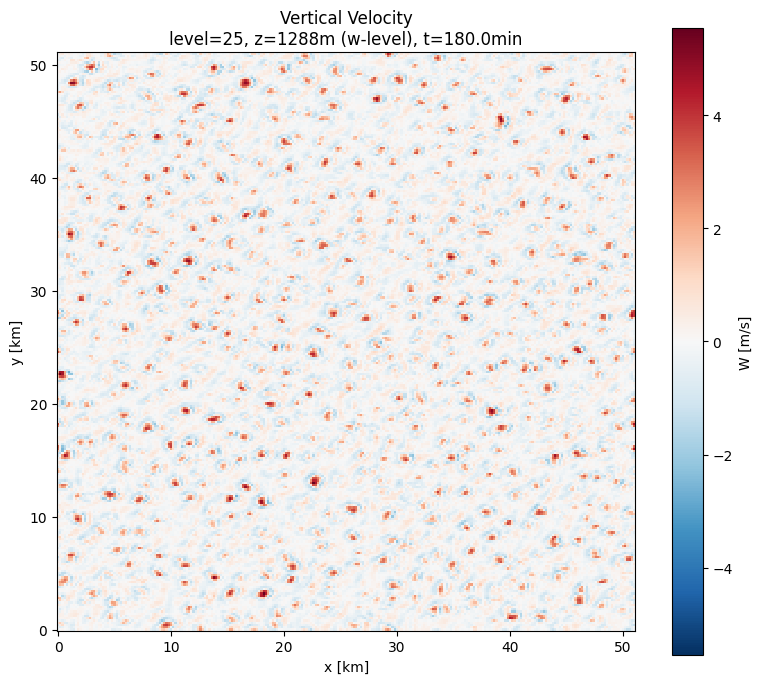

In [62]:
# Vertical velocity horizontal slice
# Note: w is on z levels, get height from z coordinate
height_w = ds.z.isel(z=z_level).values
w_slice = ds.w.isel({TIME_DIM: time_idx, 'z': z_level})

fig, ax = plt.subplots(figsize=(8, 7))

# Use .values to convert from dask array to numpy (fixes matplotlib error)
w_data = w_slice.values
vmax = max(abs(w_data.min()), abs(w_data.max()))
im = ax.pcolormesh(
    ds.x.values / 1000, ds.y.values / 1000, w_data,
    shading='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax
)
plt.colorbar(im, ax=ax, label='W [m/s]')

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title(f'Vertical Velocity\nlevel={z_level}, z={height_w:.0f}m (w-level), t={actual_time_min:.1f}min')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 6. Vertical Cross-Section

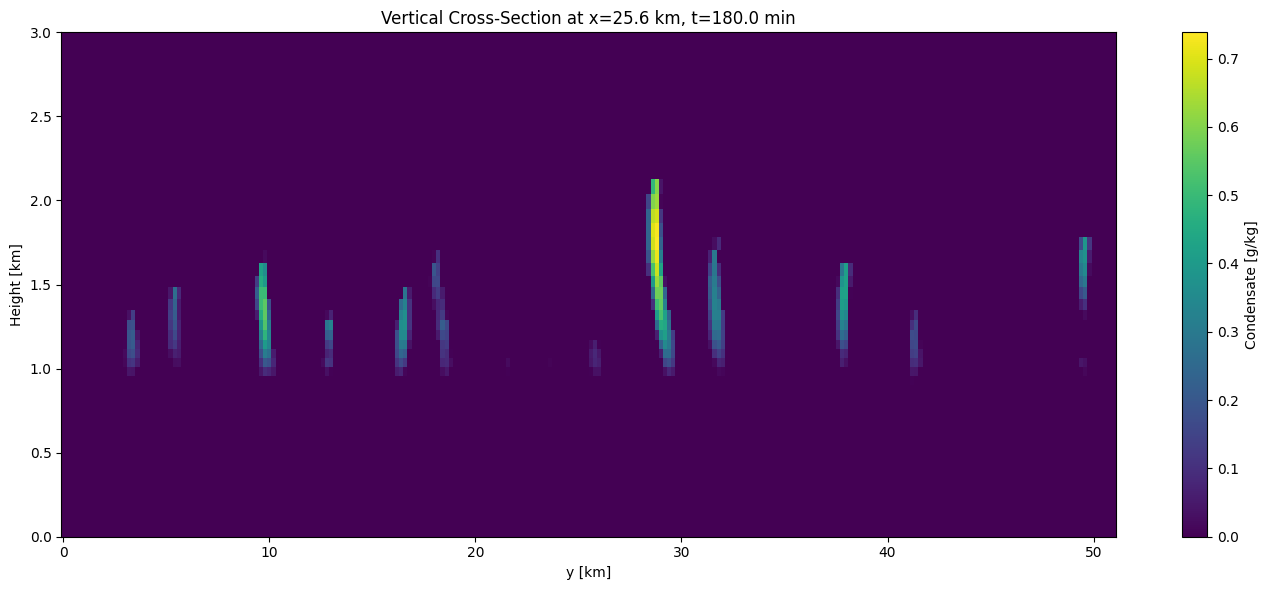

In [63]:
# Vertical cross-section (y-z) at fixed x
x_idx = ds.sizes['x'] // 2  # Middle of domain

cond_xsec = condensate.isel({TIME_DIM: time_idx, 'x': x_idx})

fig, ax = plt.subplots(figsize=(14, 6))

im = ax.pcolormesh(
    ds.y / 1000, ds.zn / 1000, cond_xsec.transpose('zn', 'y') * 1000,
    shading='auto', cmap='viridis'
)
plt.colorbar(im, ax=ax, label='Condensate [g/kg]')

ax.set_xlabel('y [km]')
ax.set_ylabel('Height [km]')
ax.set_title(f'Vertical Cross-Section at x={ds.x.isel(x=x_idx).values/1000:.1f} km, t={actual_time_min:.1f} min')
ax.set_ylim([0, 3])

plt.tight_layout()
plt.show()

## 7. Animation (Optional)

Create animated GIF of vertical cross-sections. Only run if multiple timesteps are available.

In [67]:
# Only run if multiple timesteps
if n_times < 2:
    print("Animation requires multiple timesteps. Skipping.")
else:
    time_indices = list(range(min(n_times, 20)))  # Max 10 frames
    x_idx = ds.sizes['x'] // 2
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    def update_frame(frame):
        ax.clear()
        
        cond_slice = condensate.isel({TIME_DIM: frame, 'x': x_idx})
        t_min = time_sec[frame] / 60
        
        im = ax.pcolormesh(
            ds.y / 1000, ds.zn / 1000, 
            cond_slice.transpose('zn', 'y') * 1000,
            shading='auto', cmap='viridis', vmin=0, vmax=0.1
        )
        
        ax.set_xlabel('y [km]')
        ax.set_ylabel('Height [km]')
        ax.set_title(f'Condensate at t = {t_min:.1f} minutes')
        ax.set_ylim([0, 3])
        
        return [im]
    
    anim = animation.FuncAnimation(
        fig, update_frame, frames=time_indices,
        blit=False, interval=1000
    )
    
    anim.save('lba_condensate_xsection.gif', writer='pillow', fps=1)
    plt.close()
    print("Animation saved to lba_condensate_xsection.gif")

Animation saved to lba_condensate_xsection.gif


## 8. Statistical Summary

In [65]:
# Cloud statistics over time
print("Cloud Statistics Over Time")
print("=" * 60)

# Cloud fraction (using 1e-5 kg/kg threshold for cloud liquid)
cloud_mask = ds.q_cloud_liquid_mass > 1e-5
cloud_fraction = cloud_mask.sum(dim=['x', 'y', 'zn']) / cloud_mask.size * cloud_mask.sizes[TIME_DIM]

print(f"\nTimestep | Time [min] | Cloud Fraction [%]")
print("-" * 45)
for t in range(n_times):
    cf = cloud_mask.isel({TIME_DIM: t}).sum().values / (cloud_mask.sizes['x'] * cloud_mask.sizes['y'] * cloud_mask.sizes['zn'])
    print(f"{t:8d} | {time_min[t]:10.1f} | {cf * 100:17.3f}")

Cloud Statistics Over Time

Timestep | Time [min] | Cloud Fraction [%]
---------------------------------------------
       0 |      120.0 |             0.000
       1 |      123.0 |             0.000
       2 |      126.0 |             0.000
       3 |      129.0 |             0.000
       4 |      132.0 |             0.000
       5 |      135.0 |             0.001
       6 |      138.0 |             0.019
       7 |      141.0 |             0.085
       8 |      144.0 |             0.159
       9 |      147.0 |             0.182
      10 |      150.0 |             0.161
      11 |      153.0 |             0.146
      12 |      156.0 |             0.147
      13 |      159.0 |             0.163
      14 |      162.0 |             0.207
      15 |      165.0 |             0.273
      16 |      168.0 |             0.350
      17 |      171.0 |             0.438
      18 |      174.0 |             0.521
      19 |      177.0 |             0.581
      20 |      180.0 |             0.632


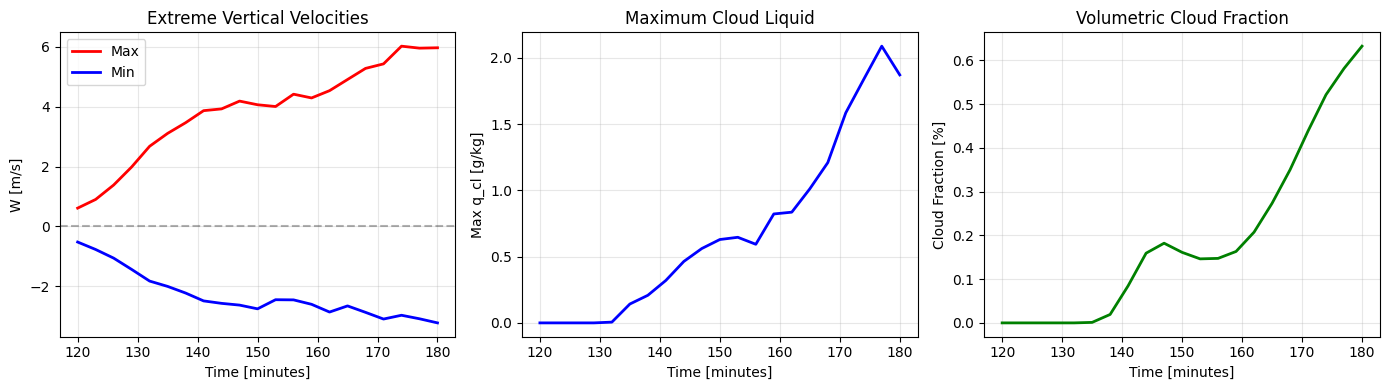

In [66]:
# Max values over time
max_w = ds.w.max(dim=['x', 'y', 'z']).values
min_w = ds.w.min(dim=['x', 'y', 'z']).values
max_qcl = ds.q_cloud_liquid_mass.max(dim=['x', 'y', 'zn']).values * 1000  # g/kg

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(time_min, max_w, 'r-', linewidth=2, label='Max')
axes[0].plot(time_min, min_w, 'b-', linewidth=2, label='Min')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Time [minutes]')
axes[0].set_ylabel('W [m/s]')
axes[0].set_title('Extreme Vertical Velocities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_min, max_qcl, 'b-', linewidth=2)
axes[1].set_xlabel('Time [minutes]')
axes[1].set_ylabel('Max q_cl [g/kg]')
axes[1].set_title('Maximum Cloud Liquid')
axes[1].grid(True, alpha=0.3)

# Cloud fraction time series
cf_time = []
for t in range(n_times):
    cf = cloud_mask.isel({TIME_DIM: t}).sum().values / (cloud_mask.sizes['x'] * cloud_mask.sizes['y'] * cloud_mask.sizes['zn'])
    cf_time.append(cf * 100)

axes[2].plot(time_min, cf_time, 'g-', linewidth=2)
axes[2].set_xlabel('Time [minutes]')
axes[2].set_ylabel('Cloud Fraction [%]')
axes[2].set_title('Volumetric Cloud Fraction')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()